## Programación Cuadrática
### Estimación de Pesos de un Indice Bursátil
Este cuaderno muestra un ejemplo de como utilizar una
optimización de mínimos cuadrados con restricciones para estimar
los pesos de los componentes del IBEX35

In [18]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

In [19]:
import pickle
with open('../data/stock_data.pkl','rb') as f:
    stock_data = pickle.load(f)
with open('../data/benchmark.pkl','rb') as f:
    benchmark_data = pickle.load(f)
    

In [20]:
stock_close = pd.DataFrame({
    ticker: df.close for ticker, df in stock_data.items()
})

In [21]:
stock_close.head()

,SAN,BTO_1,BKIA_0,BKIA,NTGY,TRE,ACX_0,ACX,FER,ACS,...,DRC,PRS_0,PRS_1,SCYR_0,TEM,CAR,AGS,COL_0,A3TV,SGC
2003-01-02,2.251615,NaN,NaN,NaN,7.363463,NaN,4.761374,NaN,NaN,4.815096,...,16.50,49.590521,NaN,4.732566,5.88,NaN,NaN,NaN,NaN,9.35
2003-01-03,2.166648,NaN,NaN,NaN,7.270788,NaN,4.865828,NaN,NaN,4.815096,...,16.84,48.960800,NaN,4.740697,5.87,NaN,NaN,NaN,NaN,9.36
2003-01-07,2.251615,NaN,NaN,NaN,7.388738,NaN,4.778783,NaN,NaN,4.815096,...,16.29,48.488510,NaN,4.667513,6.03,NaN,NaN,NaN,NaN,9.19
2003-01-08,2.251615,NaN,NaN,NaN,7.582514,NaN,4.717851,NaN,NaN,4.905021,...,16.31,48.016219,NaN,4.651250,6.02,NaN,NaN,NaN,NaN,8.83
2003-01-09,2.251615,NaN,NaN,NaN,7.641489,NaN,4.752669,NaN,NaN,4.913196,...,16.51,47.543928,NaN,4.708171,6.13,NaN,NaN,NaN,NaN,9.26


Trabajaremos con una ventana de 35 dias para simular una matriz cuadrada
de 35x35 que sería suficiente para resolver el problema de minimos cuadrados
de forma algebraica

In [22]:
win_data = stock_close.loc['2020-07-06':'2020-08-21']
win_data = win_data.dropna(axis=1)

In [23]:
print(win_data.shape)
win_data.head()

(35, 35)


,SAN,BKIA,NTGY,ACX,FER,ACS,ELE,SAB,AMS,AENA,...,BKT,ENC,IDR,SGRE,MEL,REE,COL,TEF,CABK,ALM
2020-07-06,2.3370,1.0715,16.683576,7.390,24.24,23.89,23.45,0.3360,48.78,126.6,...,4.414,2.934,7.27,16.201796,4.054,17.145,8.197825,4.211,2.0780,11.70
2020-07-07,2.2675,1.0460,16.683576,7.426,24.08,23.40,23.51,0.3302,48.55,124.4,...,4.323,2.815,7.20,16.481052,3.912,16.930,7.910096,4.075,2.0150,11.71
2020-07-08,2.2160,1.0240,16.560902,7.242,23.41,23.13,23.63,0.3157,47.05,122.2,...,4.198,2.812,7.07,16.431185,3.824,16.915,7.810000,4.000,1.9755,11.51
2020-07-09,2.1745,1.0180,16.330276,7.174,23.12,22.78,23.41,0.3117,45.07,120.0,...,4.128,2.758,6.92,17.079456,3.688,16.900,7.745000,3.950,1.9515,11.45
2020-07-10,2.2200,1.0580,16.448043,7.246,23.21,23.79,23.86,0.3264,45.74,120.0,...,4.274,2.850,6.88,17.263964,3.718,16.900,7.895000,3.999,1.9940,11.36


In [24]:
ibex_close = benchmark_data['ibex_div'].close
win_ibex = ibex_close.reindex(win_data.index)
win_ibex.head()

2020-07-06    22408.0
2020-07-07    22099.5
2020-07-08    21825.6
2020-07-09    21559.0
2020-07-10    21809.7
Name: close, dtype: float64

Convertimos los precios a precios relativos respecto al primer
día de la ventana 

In [25]:
prices_norm = win_data.apply(lambda s: s/s.iloc[0])
ibex_norm = win_ibex/win_ibex.iloc[0]

In [26]:
prices_norm.head()

,SAN,BKIA,NTGY,ACX,FER,ACS,ELE,SAB,AMS,AENA,...,BKT,ENC,IDR,SGRE,MEL,REE,COL,TEF,CABK,ALM
2020-07-06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2020-07-07,0.970261,0.976202,1.000000,1.004871,0.993399,0.979489,1.002559,0.982738,0.995285,0.982622,...,0.979384,0.959441,0.990371,1.017236,0.964973,0.987460,0.964902,0.967704,0.969682,1.000855
2020-07-08,0.948224,0.955670,0.992647,0.979973,0.965759,0.968188,1.007676,0.939583,0.964535,0.965245,...,0.951065,0.958419,0.972490,1.014158,0.943266,0.986585,0.952692,0.949893,0.950674,0.983761
2020-07-09,0.930466,0.950070,0.978824,0.970771,0.953795,0.953537,0.998294,0.927679,0.923944,0.947867,...,0.935206,0.940014,0.951857,1.054171,0.909719,0.985710,0.944763,0.938019,0.939124,0.978632
2020-07-10,0.949936,0.987401,0.985882,0.980514,0.957508,0.995814,1.017484,0.971429,0.937679,0.947867,...,0.968283,0.971370,0.946355,1.065559,0.917119,0.985710,0.963060,0.949656,0.959577,0.970940


#### Las variables de decisión
- los pesos de cada componente
- el término de error para cada día

In [27]:
window = 35
n_stocks = prices_norm.shape[1]
var_w = cp.Variable(n_stocks)
var_epsilon = cp.Variable(window)

#### Restricciones

- Para cada día queremos que el precio relativo por el peso de cada componente se parezca al valor del precio relativo del indice 
- La suma de los pesos debe ser 1
- Podemos limitar los pesos máximos y minimos. Como requerimiento debemos al menos asegurar que los pesos son positivos 

In [28]:
c_changes = []
for i in range(window):
    i_constraint = cp.sum(cp.multiply(var_w, prices_norm.iloc[i].values)) - ibex_norm[i] == var_epsilon[i] 
    c_changes.append(i_constraint)

constraints = [
    var_w <= 0.25, 
    var_w >= 0.003, 
    cp.sum(var_w) <= 1.0,
    cp.sum(var_w) >= 1.0
]        
constraints.extend(c_changes)

#### Función objetivo
Minimizar la suma de los cuadrados de los errores diarios respecto al indice

In [29]:
objective = cp.Minimize( cp.sum_squares(var_epsilon))

Resolvemos el problema y almacenamos el resultado de los pesos

In [30]:
prob = cp.Problem(objective, constraints)
prob.solve()

3.362772464885451e-08

In [31]:
errors = pd.Series(var_epsilon.value)
index_weights = pd.Series(var_w.value, index=prices_norm.columns)

Las variables de decisión estan referenciando a los pesos del primer
día.  Sacamos los pesos al último día de la serie

In [32]:
index_weights.sum()

0.9999822853082774

In [33]:
index_weights.sort_values(ascending=False)

IBE     0.167049
ITX     0.110085
SAN     0.100098
TEF     0.061154
CLNX    0.059161
AMS     0.056591
FER     0.055443
BBVA    0.054871
REP     0.032359
REE     0.031703
ELE     0.029848
GRF     0.028159
AENA    0.025918
CABK    0.025271
SGRE    0.019272
ACS     0.013485
NTGY    0.013023
ENG     0.012573
IAG     0.011749
MRL     0.011654
BKT     0.010417
IDR     0.009401
MTS     0.008124
MAP     0.007962
COL     0.007846
BKIA    0.007021
SAB     0.004169
ENC     0.004067
ACX     0.003510
MEL     0.003000
MAS     0.003000
VIS     0.003000
CIE     0.003000
ALM     0.003000
ANA     0.003000
dtype: float64

Miramos los errores obtenidos por día para verificar que no existe ningún patrón relevante

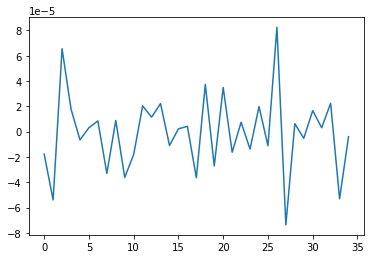

In [34]:
errors.plot()